**SECTION OBJECTIVES**
* Creating a **Decision Tree** model to predict severe damage
* Tuning model hyperparameters
* Explaining model predictions using **Gini Importance**

ML WORKFLOW:
* Preparing Data
    * Importing
    * Exploring: Not much to explore after previous section
    * Splitting: **Train-Validation-Test Split**
* Building Model
    * Baselining
    * Iterating: **Decision Tree, Ordinal Encoding, Validation Curve** `NODE`
    * Evaluating
* Communicating Results
    * Gini Importance

In [22]:
# Importing necessary libraries
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from category_encoders import OrdinalEncoder # For iterating phase

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree # For Decision Tree modeling and visualisation

warnings.simplefilter(action = 'ignore', category = FutureWarning)

# 1. Preparing Data
## 1.1 Importing
* 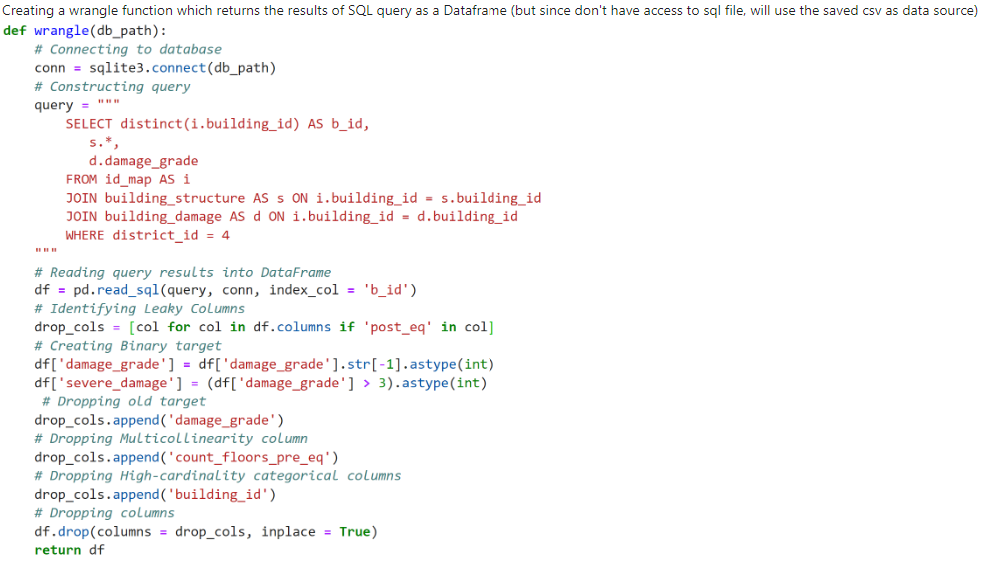

In [2]:
# Manipulating nepal-eq-dat.csv file to get data in the shape required
df = pd.read_csv('nepal_eq_data.csv', index_col = 'b_id')
drop_cols = [col for col in df.columns if 'post_eq' in col]
df['damage_grade'] = df['damage_grade'].str[-1].astype(int)
df['severe_damage'] = (df['damage_grade'] > 3).astype(int)
df.drop(columns = drop_cols, inplace = True)
df.drop(columns = ['building_id', 'count_floors_pre_eq', 'damage_grade'], inplace = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            70836 non-null  int64 
 1   plinth_area_sq_ft       70836 non-null  int64 
 2   height_ft_pre_eq        70836 non-null  int64 
 3   land_surface_condition  70836 non-null  object
 4   foundation_type         70836 non-null  object
 5   roof_type               70836 non-null  object
 6   ground_floor_type       70836 non-null  object
 7   other_floor_type        70836 non-null  object
 8   position                70836 non-null  object
 9   plan_configuration      70836 non-null  object
 10  superstructure          70836 non-null  object
 11  severe_damage           70836 non-null  int32 
dtypes: int32(1), int64(3), object(8)
memory usage: 6.8+ MB
None


,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


## 1.3 Splitting Data
### Vertical Splitting

In [3]:
target = "severe_damage"
X = df.drop(columns = target)
y = df[target]

### Randomised Train-Validation-Test Split (64:16:20)
### Validation Set
* 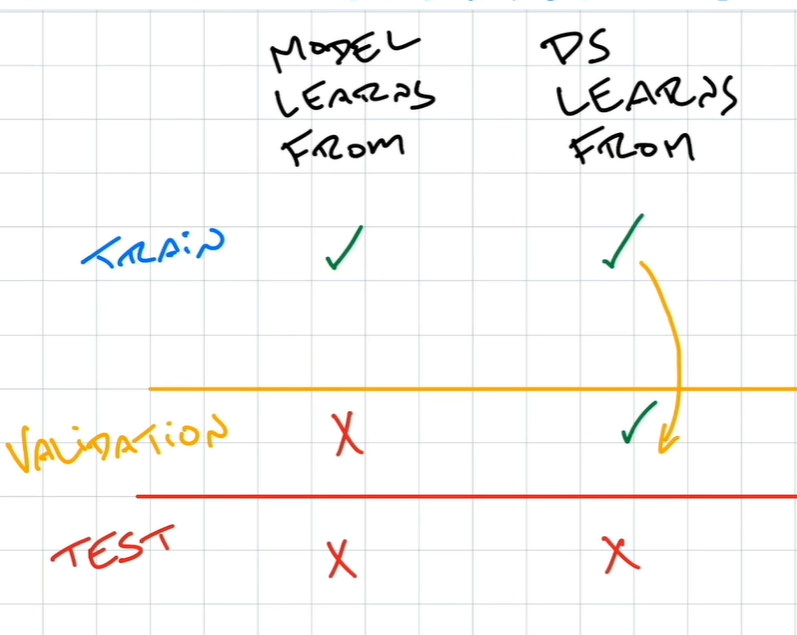
* Model has access ONLY to Training Data to learn from. NO access to Test Data
* Data Scientist also gets to see Training Data and not Test Data.
    * But Data Scientist has access to Validation Data to tune the model. Sort of mini-test
* **Hyperparameters can be tuned efficiently using the Validation set to ensure the model generalises well**
* With that information one can go back to training set, try a new set of parameters and validate again
* It is an opportunity to make adjustments without giving the model access to test data

In [4]:
# Performing a randomised train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

In [5]:
# Dividing the remaning training data into training and validation sets (80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 42
)

# 2. Building Model
## 2.1 Baselining
### Accuracy Score

In [6]:
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline, 2))

Baseline Accuracy: 0.64


## 2.2 Iterating
### Decision Tree Classifier
* A decision tree starts with all the training observations grouped together as a **Root Node**
    * In this single Node, there are two classes: severely damaged buildings and non-severely damaged buidings for our case
* Decision Tree wants to **divide** this Node into two **Child Nodes**
    * The division needs to be in such a way that these Child Nodes are `Pure` i.e. One child node contains only Severely Damaged buildings and the other node contains only not severely damaged buildings 
* This division is not always 100% purity on first division. If that's the case then the nodes are split again to achieve more purity
    * These final Nodes are referred to as **Terminal Nodes** or **Leafs**
* The number of splits required by Decision Tree to get from Root Node to Terminal/Leaf Node is **Depth** of Decision Tree. The tree in the image below has depth of 2
    * 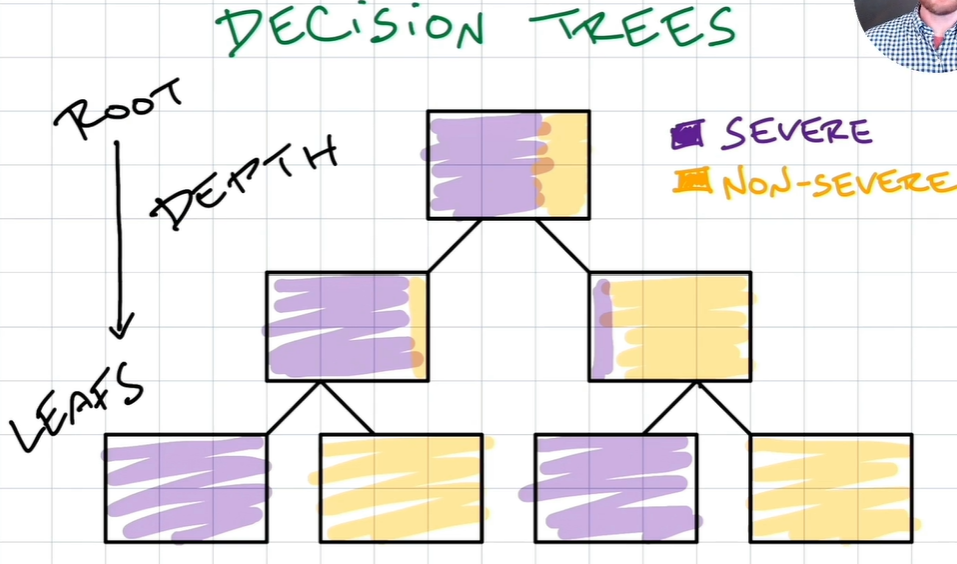



**HOW DECISION TREE MODEL WORKS**
* The model looks through all the features in the training data and attempts to find a feature and a cutoff within that feature that would help it make divisions into Pure Nodes
* Comparison of Linear Regression Model with Decision Trees
* 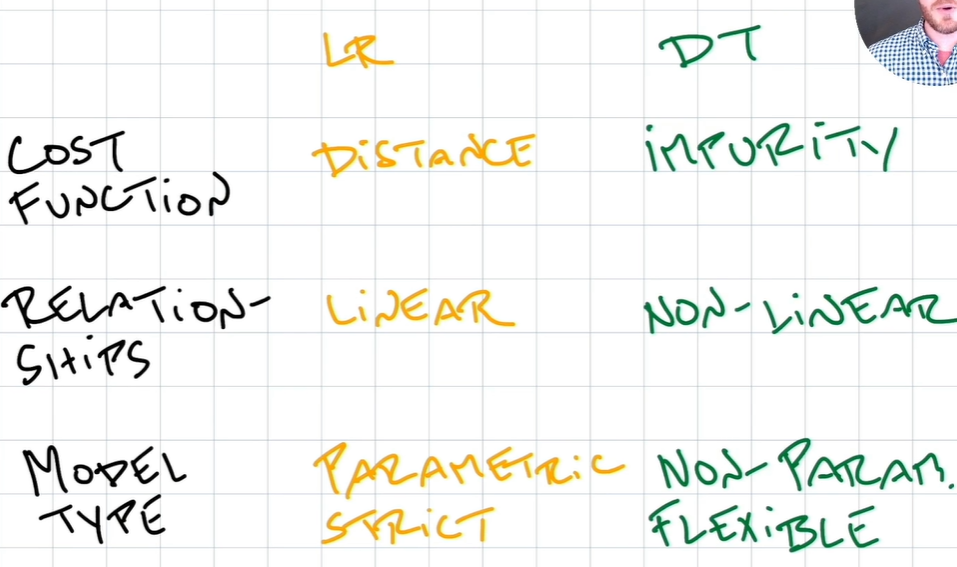

### Ordinal Encoder
* Called as such because encoding occurs in order (1,2,3..)
* Ordinal Encoding can not be used with a Linear model, which is primarily concerned with distance, because mathematical operations can not be performed on categorical data
* But for a Classification model like Decision Tree that's not a problem, because our primary aim is to divide data into Pure. Nodes
* One Hot Encoding leads to imbalanced trees, that's why it is not used in Decision Trees
* Ordinal Encoding sidesteps the dimensionality problem encountered in Linear Equations

In [7]:
# Building Model
# Edit: Inserting `max_depth` as 6 after validating and tuning hyperparameter
model = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth = 6, random_state = 42) 
    # Random state process looks through the various features in the data in a random order
)

# Fitting model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Others                              9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                   

## 2.3 Evaluating Model
**Calculating training and validation accuracy scores for model**
Either way can be used

In [8]:
# Edit: Recalculated after setting `max_depth` to 6 above
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_val = model.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation set Accuracy:", round(acc_val, 2))

Training Accuracy: 0.72
Validation set Accuracy: 0.72


### Tree Depth
* A decision tree model can make as many splits it wants until it gets to absolute purity
* A Decision tree model, if not checked, can fit the training data so well that it actually begins to describe random characteristics and loses the ability to generalise other data
* **As depth increases in a decision tree, it gets more locked onto training data and the likelihood of Overfitting increases**
* As it turns out, Depth of a Decision Tree is a Hyperparameter which can be tuned

In [9]:
# Using `get_depth` method on `DecisionTreeClassifier` in our model to check the Decision Tree depth
tree_depth = model.named_steps['decisiontreeclassifier'].get_depth()
print('Tree Depth:', tree_depth)

Tree Depth: 6


### Hyperparameter Tuning 
* Max tree depth of 49 is way too much
* But since tree depth is a Hyperparameter, it can be optimised
* We need to come up with a range for tuning tree depth

In [10]:
# Creating a range of possible values for max_depth hyperparameter
depth_hyperparams = range(1, 50, 2)

**Training model for every `max_depth` in `depth_hyperparams`**

In [1]:
# Creating empty lists for training and validation accuracy scores for different values of hyperparameter `max_depth`
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=d, random_state=42))
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

NameError: name 'depth_hyperparams' is not defined

It turns out that these scores are above baseline, which is great

### Validation Curve 
**Plotting `training_acc` and `validation_acc` scores from above as a function of `depth_hyperparams`**

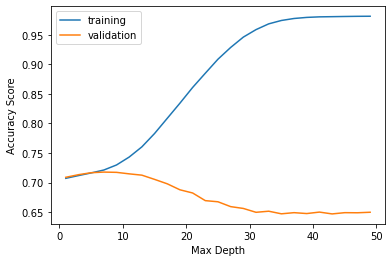

In [12]:
plt.plot(depth_hyperparams, training_acc, label = 'training')
plt.plot(depth_hyperparams, validation_acc, label = 'validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend();

* Max_depth i.e. flexibility of the plot increases from left to right
* with increasing flexibility, model is able to predict training data with more accuracy
* But the generalisability of model deteriorates as max_depth increases, which can be seen from dwindling validation accuracy scores
* It turns out that the sweet spot for `max_depth` hyperparameter is somewhere between 5-7

### Evaluating Model
** Inserting this new `max_depth` value as 6 in the Model in Input [7] and recalculating accuracy scores**
* Training Accuracy: 0.72
* Test Accuracy: 0.72

#### Checking Accuracy score for Test Set

In [13]:
test_acc = model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.72


# 3.0 Communicating Results
## Plotting Tree Model

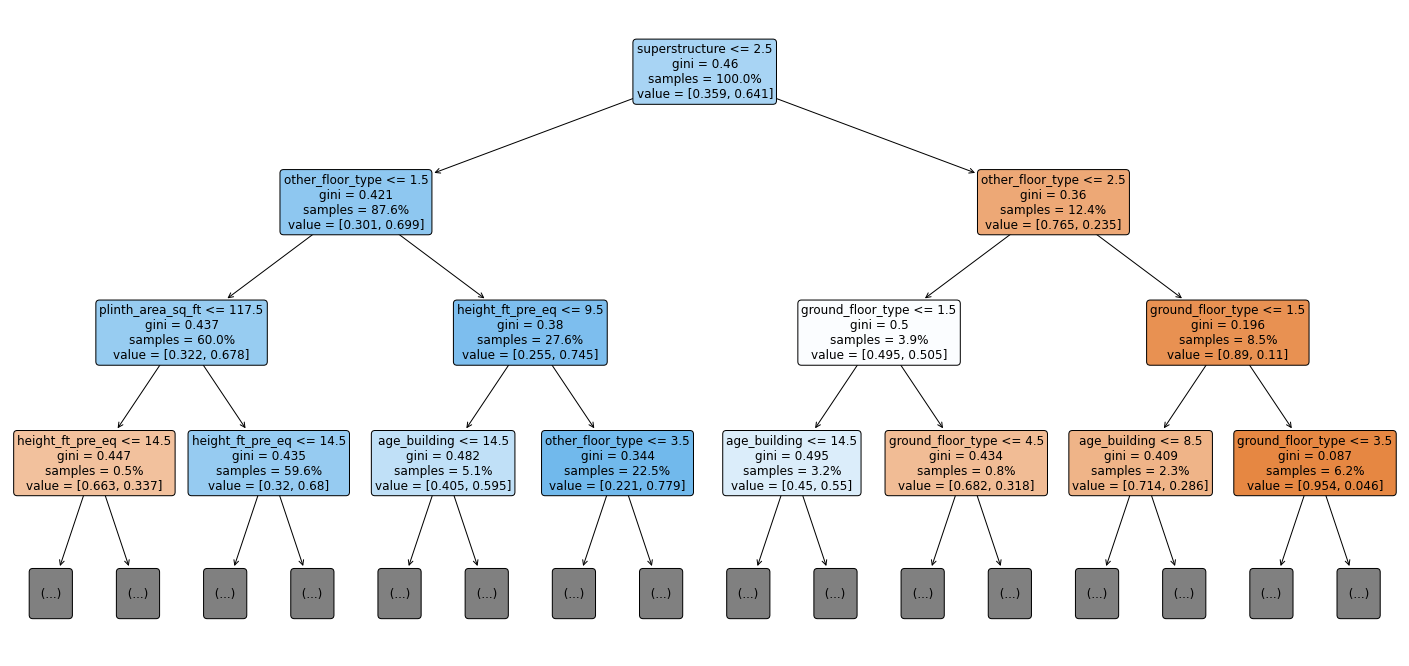

In [16]:
# Creating larger figure
fig, ax = plt.subplots(figsize = (25, 12))
# Plotting tree
plot_tree(
    decision_tree = model.named_steps['decisiontreeclassifier'],
    feature_names = X_train.columns,
    filled=True,  # Coloring leaf with class
    rounded=True,  # Rounding leaf edges
    proportion=True,  # Displaying proportion of classes in leaf
    max_depth=3,  # Only displaying first 3 levels
    fontsize=12,  # Enlarging font
    ax=ax,  # Placing in figure axis
);

### Interpreting the Decision Tree
* Each Node has 4 pieces of information:
    * How the tree is doing the split: Superstructure in Node 1 is Ordinally Encoded and divided into two groups
    * It gives Gini, a measure of Impurity. It is a cost function and the model aims to bring it closer to 0
    * Number of total samples is then displayed
    * The model also indicates the proportion of these samples 
* As further divisions are made down the decision tree, the nodes get increasingly Blue (Severealy Damaged) or increasingly Orange (less severely damaged)
* It can be observed that some features have been used multiple times in the tree for node splitting (e.g. `heaight_ft_pre_eq`). It could be attributes to their **gini importance**

## Extracting Feature Importances

In [17]:
features = X_train.columns
importances = model.named_steps['decisiontreeclassifier'].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq'], dtype='object')
Importances: [0.03515085 0.04618639 0.08839161]


### Creating Series for Feature Importances

In [21]:
feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.head()

position                  0.000644
plan_configuration        0.004847
foundation_type           0.005206
roof_type                 0.007620
land_surface_condition    0.020759
dtype: float64

In [23]:
# Summing all feature importances
feat_imp.sum()

0.9999999999999999

**The sum of all Feature Importances approaches 1**

## Charting Gini Importance

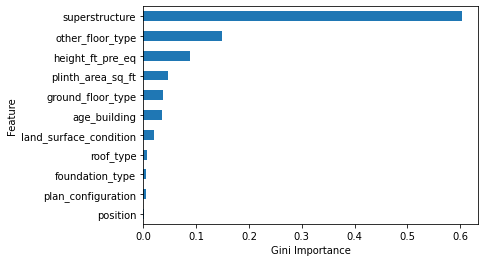

In [24]:
# Creating Horizontal bar chart
feat_imp.plot(kind = 'barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature');

### Interpreting Gini Importance
* It can be seen that gini importance for all features exists between 0-1 and all of them put together add up to 1
* 0.6 for `superstructure` means that this feature is responsible for over 60% increase/decrease in impurity over the course of splits from root to leaves
* Gini Importance signifies the importance of a particular feature in dividing the data from impure root node to pure leaf nodes
* Unlike in a Linear Model where manipulating features led to changes in predicting the target value, manipulating the features in a Decision Tree model would not have the same bearing on the final outcome. There is no such connection
* Another observation is that unlike a Linear Model, in a Decision Tree all features have a positive coefficient. It implies that we can not know whether a feature is exerting an upward or downward pressure on the target vector
* For these reasons it can be argued that Linear Models are better at explanability.
* It is therefore a tradeoff among explanability, computing power and performance when choosing which model to choose for our purpose